# Laboratório 3: Bacteria

### Referente ao capítulo 7

Nesse laboratório, queremos controlar o crescimento de uma população de bactérias através do uso de um químico, que acelera o crescimento da população de bactéria e também cria um produto secundário com efeito negativo, como descrito abaixo na equação diferencial. Seja $u(t)$ a quantidade de químico adicionado. Nesse meio, queremos maximizar a quantidade de bactérias no tempo final, com a menor quantidade de químico possível. Consideramos o intervalo de tempo $[0,1]$

## O problema

$$
\max_u Cx(1) - \int_0^1 u(t)^2 dt \\
\text{sujeito a  }x'(t) = rx(t) + Au(t)x(t) - Bu(t)^2e^{-x(t)}, x(0) = x_0
$$
tal que $A,B,C \geq 0$.

$A$ é o parâmetro da força do químico em crescer a população, enquanto $B$ mede a força do efeito negativo. 

É fácil notar que $f$ e $g$ são continuamente diferenciáveis e côncavas em $x$ e $u$. Vamos verificar as condições necessárias. 

## Condições Necessárias 

### Hamiltoniano

$$
H = - u(t)^2 + \lambda(t)[rx(t) + Au(t)x(t) - Bu(t)^2e^{-x(t)}]
$$

### Condição de otimalidade

$$
0 = H_u = -2u + A\lambda x - 2B\lambda u e^{-x} \implies u^*(t) = \frac{A\lambda x}{2 + 2B\lambda e^{-x}}
$$

### Equação adjunta 

$$
\lambda '(t) = - H_x = - \lambda(t)\left(r + Au(t) + Bu(t)^2e^{-x(t)}\right)
$$

### Condição de transversalidade 

$$
\lambda(1) = \phi '(x) = C
$$  

Temos que provar que $\lambda(t) \ge 0$. Observe que, utilizando matemática de EDOs, 

$$\lambda(t) = \lambda(0)\exp\left\{-\int \left(r + Au(s) + Bu(s)^2e^{-x(s)}\right) ds\right\}$$

Se $\lambda(0) < 0$, então $\lambda(1) = C < 0$, o que é um absurdo, dado que $C \ge 0$. Portanto $\lambda(t) \ge 0$. 

### Importanto as bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sp

import sys  
sys.path.insert(0, '../pyscripts/')

from optimal_control_class import OptimalControl

In [2]:
x_sp, u_sp, lambda_sp, r_sp, A_sp, B_sp = sp.symbols('x u lambda r A B')
H = - u_sp**2 + lambda_sp*(r_sp*x_sp + A_sp*u_sp*x_sp - B_sp*u_sp**2*sp.exp(-x_sp))

Mais uma vez usaremos a biblioteca de matemática simbólica para fazer as derivadas

In [3]:
print('H_x = {}'.format(sp.diff(H,x_sp)))
print('H_u = {}'.format(sp.diff(H,u_sp)))
print('H_lambda = {}'.format(sp.diff(H,lambda_sp)))

H_x = lambda*(A*u + B*u**2*exp(-x) + r)
H_u = lambda*(A*x - 2*B*u*exp(-x)) - 2*u
H_lambda = A*u*x - B*u**2*exp(-x) + r*x


Podemos resolver a equação $H_u = 0$, mas esse passo é importante conferir manualmente também

In [4]:
eq = sp.Eq(sp.diff(H,u_sp), 0)
sp.solve(eq,u_sp)

[A*lambda*x*exp(x)/(2*(B*lambda + exp(x)))]

Dessa vez vamos utilizar uma classe escrita em Python que codifica o algoritmo apresentado no Capítulo 5 e no Laboratório 1.

Primeiro precisamos definir as equações importantes das condições necessárias. É importante escrever no formato descrito nesse notebook. par é um dicionário com os parâmetros específicos do modelo. Agora vamos precisar usar o tempo payoff. 

In [5]:
parameters = {'r': None, 'A': None, 'B': None, 'C': None}

diff_state = lambda t, x, u, par: par['A']*u*x - par['B']*u**2*np.exp(-x) + par['r']*x
diff_lambda = lambda t, x, u, lambda_, par: - lambda_*(par['B']*u**2*np.exp(-x) +  \
                                                       par['r'] + par['A']*u)           
update_u = lambda t, x, lambda_, par: par['A']*lambda_*x*np.exp(x)/(2*(par['B']*lambda_ + \
                                                                     np.exp(x)))
diff_payoff = lambda x, par: par['C']

## Aplicando a classe ao exemplo 

Vamos fazer algumas exeperimentações. Sinta-se livre para variar os parâmetros.

In [6]:
problem = OptimalControl(diff_state, diff_lambda, update_u, diff_phi = diff_payoff)

In [7]:
x0 = 1
T = 1
parameters['A'] = 1
parameters['B'] = 12
parameters['C'] = 1
parameters['r'] = 1

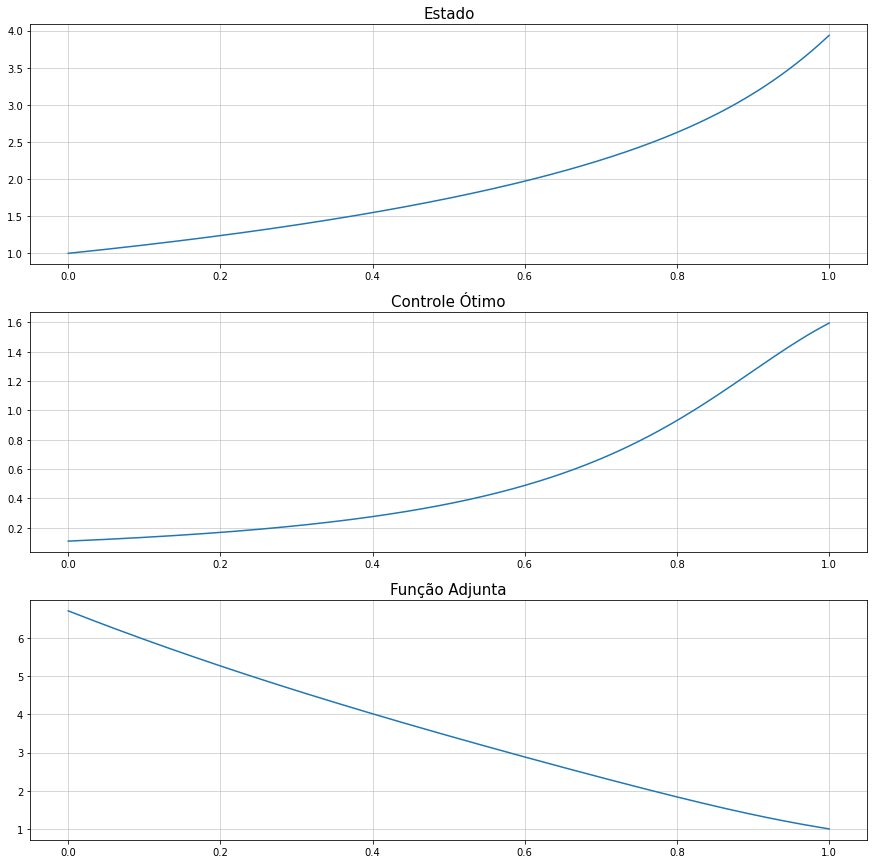

In [8]:
t,x,u,lambda_ = problem.solve(x0, T, parameters)
ax = problem.plotting(t,x,u,lambda_)

Vemos que a concentração do químico se dá no final do intervalo. Quando $x$ cresce, o termo exponencial decresce e, portanto, o produto secundário perde efeito. O que faz com que o aumento do químico causa efeito mais positivo no nível de bactérias, e portanto a derivada de $x$ cresce mais no decorrer. 

### Variando a condição inicial

Observe que pequenas variações no valor inicial geram valores mais altos da quantidade de bactérias. Quanto mais próximo de $1.15$, mais problemas numéricos começam a aparecer. 

In [9]:
x0_values = [0.9, 1.0, 1.1, 1.1495]
x_values = []
for x0 in x0_values: 
    _,x,_,_ = problem.solve(x0, T, parameters)
    x_values.append(x)

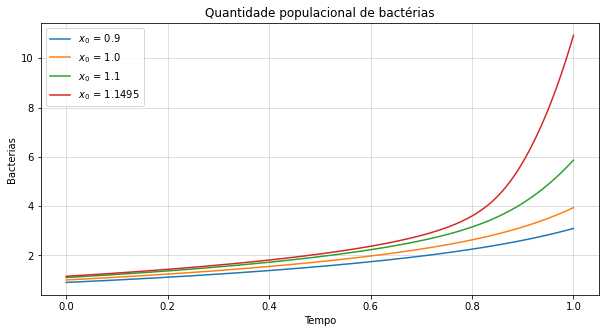

In [10]:
fig = plt.figure(figsize = (10,5))
plt.xlabel("Tempo")
plt.ylabel("Bacterias")
plt.title("Quantidade populacional de bactérias")
for i, x0 in enumerate(x0_values):
    plt.plot(t, x_values[i],label = r'$x_0$ = {}'.format(x0))
plt.legend()
plt.grid(alpha = 0.5)

### Variando o efeito do químico

O aumento do parâmetro $A$ deve aumentar o efeito positivo do químico para o crescimento da bactéria. Isso deve gerar um aumento no uso do químico para aumentar $x(1)$.  

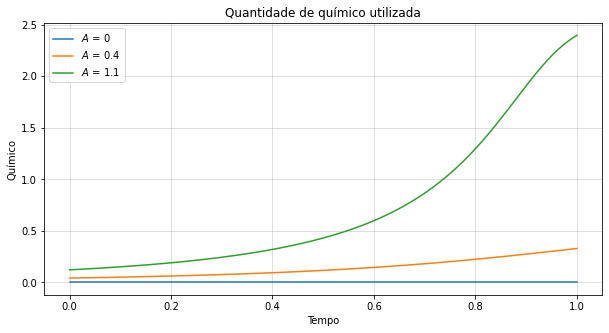

In [11]:
x0 = 1
A_values = [0, 0.4, 1.1]
u_values = []
for A in A_values: 
    parameters['A'] = A
    _,_,u,_ = problem.solve(x0, T, parameters)
    u_values.append(u)
    
fig = plt.figure(figsize = (10,5))
plt.xlabel("Tempo")
plt.ylabel("Químico")
plt.title("Quantidade de químico utilizada")
for i, A in enumerate(A_values):
    plt.plot(t, u_values[i],label = r'$A$ = {}'.format(A))
plt.legend()
plt.grid(alpha = 0.5)

## Experimentação 

Descomente a célula a seguir e varie os parâmetros para ver seus efeitos: 

1. Aumentar $r$ para ver o crescimento das bactérias. O que isso gera na quantidade de químico? 
2. Variar $B$ deve causar que tipo de efeito? 

In [12]:
#x0 = 1
#parameters['r'] = 1
#parameters['A'] = 1
#parameters['B'] = 12
#parameters['C'] = 1
#
#t,x,u,lambda_ = problem.solve(x0, T, parameters)
#roblem.plotting(t,x,u,lambda_)